# Experiment 2
Checking whether batchnorm affects Internal Covariate Shift

In [2]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.nn as nn
from torch import optim
from torch.autograd import Variable
import scipy.io as sio
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
import wandb

In [3]:
# download the cifar10 dataset
trainset = datasets.CIFAR10(root='/scratch/cifar10', train=True, download=True, transform=ToTensor())

Files already downloaded and verified


In [4]:
testset = datasets.CIFAR10(root='/scratch/cifar10', train=False, download=False, transform=ToTensor())

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [6]:
# print len of train
print(len(trainset))

50000


In [6]:
#create a dataloader for train and test
loaders = {
    'train': DataLoader(trainset, batch_size=256, shuffle=True, num_workers=1),
    'test': DataLoader(testset, batch_size=512, shuffle=False, num_workers=1)
}

## Comparing models with and without noise added

In [7]:
# this class is used to add a layer that adds noise to the input
# noise is added after batchnorm layers and before relu
class AddNoiseLayer(torch.nn.Module):
    # mu, sigma are mean and std of noise
    def __init__(self, n_mu, n_sigma, r_mu, r_sigma):
        super(AddNoiseLayer, self).__init__()
        self.n_mu = n_mu
        self.n_sigma = n_sigma
        self.r_mu = r_mu
        self.r_sigma = r_sigma

    def forward(self, x):
        # sample time-varying noise vectors from normal distributions for all layers and time steps at once
        # generating random mean values for the noise at each time step
        mu_t = torch.rand(x.size(0), x.size(1), x.size(2), 1, device=x.device) * 2 * self.n_mu - self.n_mu
        
        # generating random standard deviation values for the noise at each time step
        sigma_t = torch.rand(x.size(0), x.size(1), x.size(2), 1, device=x.device) * self.n_sigma + 1
        
        # creating time-varying noise by sampling from a normal distribution with the generated mean and standard deviation
        noise = torch.randn_like(x) * sigma_t + mu_t

        # adding the noise and scaling it by the standard deviation and adding the mean
        x = x + self.r_sigma * noise + self.r_mu
        return x


# This class is the actual VGG16 model
class VGG16(nn.Module):
    # init function, depends on whether noise or batchnorm layers are added
    def __init__(self, num_classes, batchnorm, noise):
        self.noise = noise
        super(VGG16, self).__init__()
        self.layer1 = self._make_layer(3, 64, batchnorm)
        self.layer2 = self._make_layer(64, 64, batchnorm, maxpool=True)
        self.layer3 = self._make_layer(64, 128, batchnorm)
        self.layer4 = self._make_layer(128, 128, batchnorm, maxpool=True)
        self.layer5 = self._make_layer(128, 256, batchnorm)
        self.layer6 = self._make_layer(256, 256, batchnorm)
        self.layer7 = self._make_layer(256, 256, batchnorm, maxpool=True)
        self.layer8 = self._make_layer(256, 512, batchnorm)
        self.layer9 = self._make_layer(512, 512, batchnorm)
        self.layer10 = self._make_layer(512, 512, batchnorm, maxpool=True)
        self.layer11 = self._make_layer(512, 512, batchnorm)
        self.layer12 = self._make_layer(512, 512, batchnorm)
        self.layer13 = self._make_layer(512, 512, batchnorm, maxpool=True)
        self.layer14 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU(),
        )
        self.layer15 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
        )
        self.layer16 = nn.Sequential(
            nn.Linear(4096, num_classes),
        )

        self.output3 = None
        self.output11 = None

    # creates specific layers for layers with batchnorm and noise
    def _make_layer(self, in_channels, out_channels, batchnorm, maxpool=False):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
        ]
        
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
            
            if self.noise:
                # used the same noise parameters as in the paper
                layers.append(AddNoiseLayer(0.5, 1.25, 0.1, 0.1))
            
        layers.append(nn.ReLU())
        
        if maxpool:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
        return nn.Sequential(*layers)

    # forward function of the model, does a forward pass on the input
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        self.output3 = out
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        self.output11 = out
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.view(out.size(0), -1)
        out = self.layer14(out)
        out = self.layer15(out)
        out = self.layer16(out)
        return out
    
    # this function is used to train the model
    def fit(self, loaders, epochs, device, learning_rate):
        self.to(device)
        # cross entropy loss and adam optimzer are used
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        out3 = []
        out11 =[]
        for epoch in tqdm(range(epochs)):
            self.train().to(device)

            total_loss = 0
            correct = 0
            total = 0

            # iterating over the train data and calculating the loss and accuracy for every 30 steps
            for i, (images, labels) in enumerate(loaders['train']):
                self.train().to(device)
                optimizer.zero_grad()

                images = images.to(device)
                labels = labels.to(device)
                
                outputs = self(images)
                loss = criterion(outputs, labels)
                
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                if(epoch % 5 == 0 and i % 30 == 0):
                    out3.append(self.output3)
                    out11.append(self.output11)
                    # wandb.log({"Epoch": epoch + 1, "Output3"})

                #     wandb.log({"Epoch": epoch + 1, "Loss": total_loss / (i + 1), "Train_Accuracy": 100 *correct / total})

        return out3, out11

In [9]:
# sweep configuration used for wandb sweeps
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'noise': {
            'values': [True, False]
        },
        'batchnorm': {
            'values': [True, False]
        },
    }
}

In [10]:
sweep_id = wandb.sweep(sweep_config, project='adding_noise')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: rj85v51e
Sweep URL: https://wandb.ai/project-ai-scream/adding_noise/sweeps/rj85v51e


In [11]:
# function for logging wandb sweeps
def wandb_logging():
    with wandb.init(config=sweep_config):
        config = wandb.config
        if config.noise and config.batchnorm:
            name = 'batchnorm, noise'
        elif config.noise:
            name = 'no batchnorm, noise'
        elif config.batchnorm:
            name = 'batchnorm, no noise'
        else:
            name = 'no batchnorm, no noise'
        wandb.run.name = name
        model = VGG16(10, config.batchnorm, config.noise)
        model.fit(loaders, 50, device, 0.0005)

In [12]:
wandb.agent(sweep_id, wandb_logging)

wandb: Agent Starting Run: z35pwdpu with config:
wandb: 	batchnorm: True
wandb: 	noise: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sanika-damle (project-ai-scream). Use `wandb login --relogin` to force relogin


100%|██████████| 50/50 [10:54<00:00, 13.09s/it]


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▇▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Accuracy,▁▂▄▅▆▆▇▇▇▇▇█████████████████████████████
Epoch,50
Loss,0.03567
Train_Accuracy,98.99646


wandb: Agent Starting Run: ukgczktf with config:
wandb: 	batchnorm: True
wandb: 	noise: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 50/50 [09:45<00:00, 11.72s/it]


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Accuracy,▁▃▅▅▆▇▇▇▇▇██████████████████████████████
Epoch,50
Loss,0.02602
Train_Accuracy,99.22522


wandb: Agent Starting Run: hcrs446n with config:
wandb: 	batchnorm: False
wandb: 	noise: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 50/50 [08:47<00:00, 10.55s/it]


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,██▇▆▅▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Accuracy,▁▁▂▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇▇█████████████████████
Epoch,50
Loss,0.05398
Train_Accuracy,98.39002


wandb: Agent Starting Run: l2lt2g0t with config:
wandb: 	batchnorm: False
wandb: 	noise: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 50/50 [08:41<00:00, 10.43s/it]


Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss,█▆▆▆▆▆▆▁▅▆▄▅▅▆▅▅▅▅▅▆▅▆▆▅▅▅▅▅▅▅▅▆▅▆▆▅▅▅▅▅
Train_Accuracy,▂▁▂▁▃▂▁█▁▁█▂▂▁▂▂▂▂▂▁▂▁▁▂▂▁▅▂▂▂▂▂▂▂▂▁▁▂▂▂
Epoch,50
Loss,2.30264
Train_Accuracy,9.71815


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


## Calculating ICS

In [41]:
# class for finding the ics for layer 5 and 10
# the base model is the same
class VGG16_finding_gradient_difference(nn.Module):
    def __init__(self, num_classes, batchnorm):
        super(VGG16_finding_gradient_difference, self).__init__()
        self.layer1 = self._make_layer(3, 64, batchnorm)
        self.layer2 = self._make_layer(64, 64, batchnorm, maxpool=True)
        self.layer3 = self._make_layer(64, 128, batchnorm)
        self.layer4 = self._make_layer(128, 128, batchnorm, maxpool=True)
        self.layer5 = self._make_layer(128, 256, batchnorm)
        self.layer6 = self._make_layer(256, 256, batchnorm)
        self.layer7 = self._make_layer(256, 256, batchnorm, maxpool=True)
        self.layer8 = self._make_layer(256, 512, batchnorm)
        self.layer9 = self._make_layer(512, 512, batchnorm)
        self.layer10 = self._make_layer(512, 512, batchnorm, maxpool=True)
        self.layer11 = self._make_layer(512, 512, batchnorm)
        self.layer12 = self._make_layer(512, 512, batchnorm)
        self.layer13 = self._make_layer(512, 512, batchnorm, maxpool=True)
        self.layer14 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 4096),
            nn.ReLU(),
        )
        self.layer15 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
        )
        self.layer16 = nn.Sequential(
            nn.Linear(4096, num_classes),
        )

    def _make_layer(self, in_channels, out_channels, batchnorm, maxpool=False):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
        ]
        
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
            
        layers.append(nn.ReLU())
        
        if maxpool:
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
        return nn.Sequential(*layers)

    # calculates the cosine similiarity between the gradients
    def cosine_similarity(self, x, y):
        cos = nn.CosineSimilarity(dim=-1, eps=1e-6)
        return cos(x.view(-1), y.view(-1))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.view(out.size(0), -1)
        out = self.layer14(out)
        out = self.layer15(out)
        out = self.layer16(out)
        return out
   
    # function to store the learnable parameters of the model (weights and biases)
    def get_weights(self):
        features_weights = []
        features_bias = []

        # the attributes of model are used to store the weights and biases
        for name, module in self.named_children():
            if hasattr(module, 'parameters'):
                params_dict = {param_name: param for param_name, param in module.named_parameters()}
                # Access weight and bias using keys
                for key in params_dict.keys():
                    if 'weight' in key:
                        features_weights.append(params_dict[key].data.clone().detach())
                    elif 'bias' in key:
                        features_bias.append(params_dict[key].data.clone().detach())
    
        return features_weights, features_bias
    
    # function to set the learnable parameters of the model, can be set till a specific layer using "feature"
    def set_weights(self, features_weights, features_bias, feature=None):
        wi = 0
        bi = 0

        # the attributes of model are used to store the weights and biases
        for name, module in self.named_children():
            if feature == 5 and name == 'layer5':
                return
            if feature == 10 and name == 'layer10':
                return
            if hasattr(module, 'parameters'):
                for param_name, param in module.named_parameters():
                    if 'weight' in param_name:
                        param.data = features_weights[wi]
                        wi += 1
                    elif 'bias' in param_name:
                        param.data = features_bias[bi]
                        bi += 1

    # function to get the gradient of a specific layer                    
    def get_gradient(self, layer_name):
        for name, module in self.named_children():
            if name == layer_name:
                if hasattr(module, 'parameters'):
                    for param_name, param in module.named_parameters():
                        if 'weight' in param_name:
                            return param.grad.clone().detach()
        return None 

    # function to train the model
    def fit(self, loaders, epochs, device, learning_rate):
        criterion = nn.CrossEntropyLoss().to(device)
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)


        for epoch in tqdm(range(epochs)):
            self.train().to(device)

            total_loss = 0
            correct = 0
            total = 0
            for i, (images, labels) in enumerate(loaders['train']):
                self.train().to(device)
                optimizer.zero_grad()
                images = images.to(device)
                labels = labels.to(device)

                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                
                if i % 60 == 0:
                    # save current weights and biases every 60 steps
                    current_features_weights, current_features_bias = self.get_weights()
                    grad_5 = self.get_gradient('layer5')
                    grad_10 = self.get_gradient('layer10')
                
                    # update weights and biases
                    optimizer.step()
                    total_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                    # save new weights and biases
                    new_features_weights, new_features_bias = self.get_weights()

                    # set weights and biases to previous values for layer 5
                    self.set_weights(current_features_weights, current_features_bias)
                    self.set_weights(new_features_weights, new_features_bias, 5)
                    optimizer.zero_grad()
                    predictions = self(images)
                    loss = criterion(predictions, labels)
                    loss.backward()
                    grad_5_new = self.get_gradient('layer5')

                    # for layer 10
                    self.set_weights(current_features_weights, current_features_bias)
                    self.set_weights(new_features_weights, new_features_bias, 10)
                    optimizer.zero_grad()
                    predictions = self(images)
                    loss = criterion(predictions, labels)
                    loss.backward()
                    grad_10_new = self.get_gradient('layer10')

                    # set weights and biases to previous values
                    self.set_weights(new_features_weights, new_features_bias)
                    other_weights, other_bias = self.get_weights()

                    # calculate ics
                    wandb.log({"Cosine Similarity Layer 5": self.cosine_similarity(grad_5, grad_5_new)})
                    wandb.log({"Cosine Similarity Layer 10": self.cosine_similarity(grad_10, grad_10_new)})
                    wandb.log({"L2 Distance Layer 5": nn.functional.pairwise_distance(grad_5.view(-1), grad_5_new.view(-1), p=2)})
                    wandb.log({"L2 Distance Layer 10": nn.functional.pairwise_distance(grad_10.view(-1), grad_10_new.view(-1), p=2)})
                    wandb.log({"Epoch": epoch + 1, "Loss": total_loss / (i + 1), "Train_Accuracy": 100 *correct / total})
                else:
                    # in case the step is not the 60th, the loss and accuracy still have to be measured
                    optimizer.step()
                    total_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()


In [43]:
# sweep configuration for wandb sweeps
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'batchnorm': {
            'values': [False, True]
        },
    }
}

In [44]:
sweep_id = wandb.sweep(sweep_config, project='cos-angle')

Create sweep with ID: iaqs0oiw
Sweep URL: https://wandb.ai/project-ai-scream/cos-angle/sweeps/iaqs0oiw


In [45]:
def wandb_logging():
    with wandb.init(config=sweep_config):
        config = wandb.config
        if config.batchnorm:
            name = 'standard+batchnorm'
        else:
            name = 'standard'
        wandb.run.name = name
        model = VGG16_finding_gradient_difference(10, config.batchnorm)
        model.fit(loaders, 50, device, 0.0003)

In [46]:
wandb.agent(sweep_id, wandb_logging)

wandb: Agent Starting Run: bf89vvdm with config:
wandb: 	batchnorm: False
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 50/50 [08:55<00:00, 10.71s/it]


Cosine Similarity Layer 10,███▇▇▆▇▆▇▆▇▇▅▂▅▅▆▆▄▃▂▅▄▆▅▄▆▇▂▆▃▄▇▁▃▅▆▆▇▆
Cosine Similarity Layer 5,█▆▇██▇▇▇▇▇▇▇▇▆▇▅█▇▇▇▇▆▇▆▇▇▆▇██▆▇▇▇▁▇▇▇▇▇
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
L2 Distance Layer 10,▁▂▃▄▄▅▄▅▃▅▄▃▆█▄▆▄▃▄▄▃▄▅▁▅▄▂▂▄▂▆▃▁▄▅▇▄▃▂▂
L2 Distance Layer 5,▁▂▂▂▃▃▃▃▃▄▄▄▄▇▄▆▃▄▄▃▃▄▃▂▃▃▂▂▃▂▆▂▂▃█▅▃▂▂▂
Loss,█▇▆▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Accuracy,▁▂▃▄▅▅▆▆▇▇▇▇▇███████████████████████████
Cosine Similarity Layer 10,0.80928
Cosine Similarity Layer 5,0.91475
Epoch,50
L2 Distance Layer 10,0.04934


wandb: Agent Starting Run: 8ytz8b0k with config:
wandb: 	batchnorm: True
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


100%|██████████| 50/50 [09:56<00:00, 11.93s/it]


Cosine Similarity Layer 10,▇███▇▇▆▇▆▇▇▆▅▇▆▅▄▃▆▅▅▃█▅▃▁▆▃▂▆▃▄▆▆▃▇▆▂▁▃
Cosine Similarity Layer 5,▇██████▇▇▇▇▇▅▇▇▇▇▆▆█▇▅▇█▇██▆▇█▆▇█▆▇▇▄▁▇▇
Epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
L2 Distance Layer 10,██▅▄▆▅▅▆█▆▃▅▄▄▄▄▄▄▂▅▄▄▂▅▂▃▃▅▅▂▃▂▂▃▄▁▁▃▄▄
L2 Distance Layer 5,▂▄▃▃▄▄▄▆▇▅▄▆▆▄▅▄▄▄▄▃▄▇▂▄▂▂▂██▁▄▃▂▄▄▁▁▆▆▄
Loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train_Accuracy,▁▄▆▆▇▇▇▇████████████████████████████████
Cosine Similarity Layer 10,0.41172
Cosine Similarity Layer 5,0.90521
Epoch,50
L2 Distance Layer 10,0.04642


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Visualising Activations of a layer

In [9]:
model_nb = VGG16(10, True, True)
model_b = VGG16(10, True, False)
model = VGG16(10, False, False)

In [13]:
nb_3, nb_11 = model_nb.fit(loaders, 30, device, 0.0005)
b_3, b_11 = model_b.fit(loaders, 30, device, 0.0005)

100%|██████████| 30/30 [06:21<00:00, 12.72s/it]


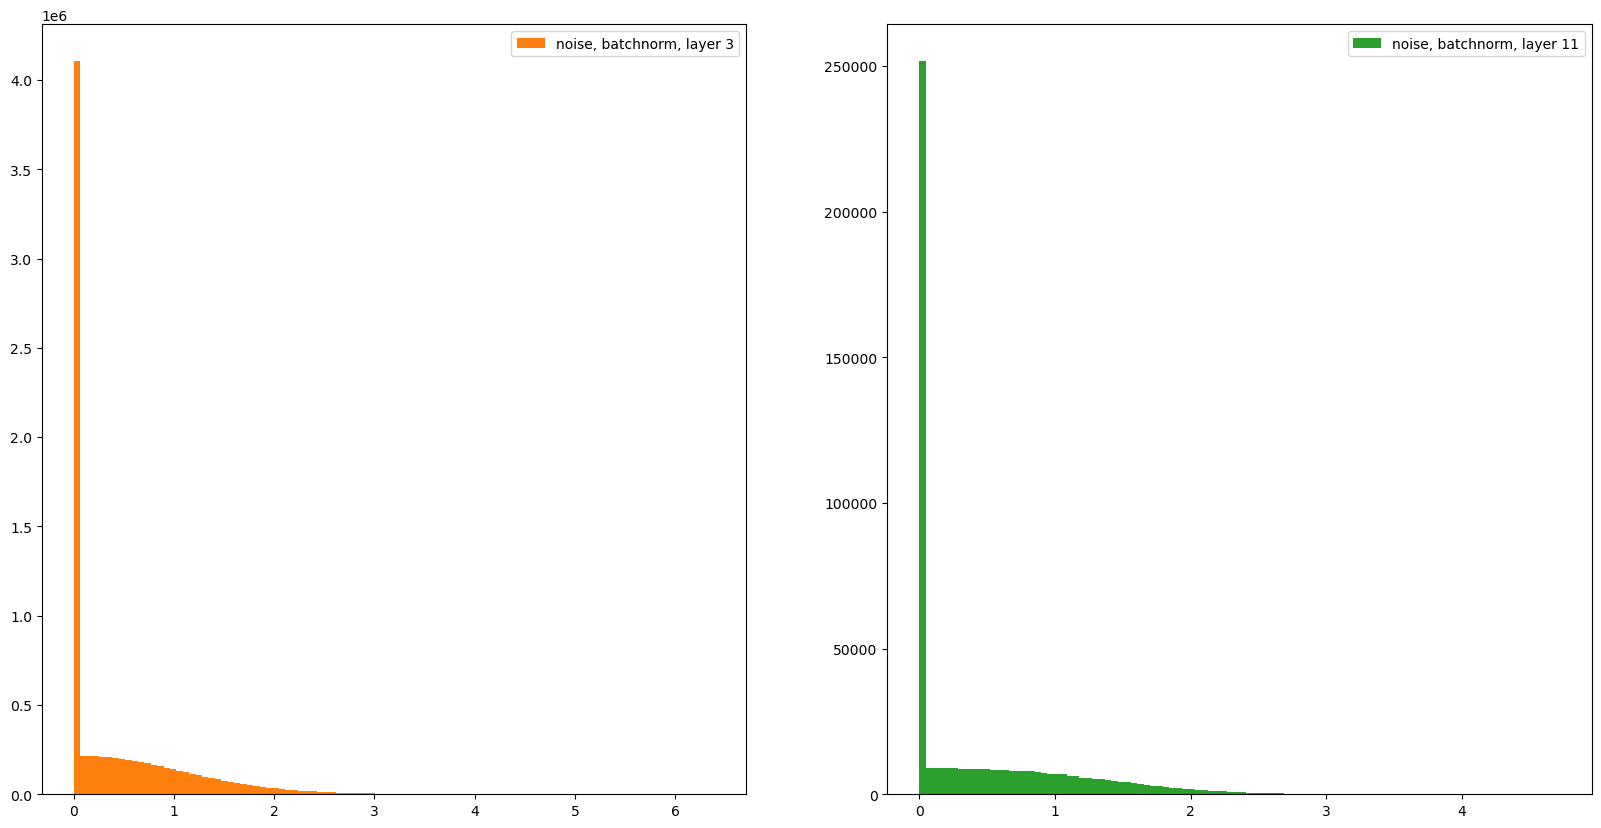

In [15]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.hist(nb_3[0].cpu().detach().numpy().flatten(), bins=100, alpha=1, label='noise, batchnorm, layer 3', color='C1')

plt.legend()
plt.subplot(1, 2, 2)
plt.hist(nb_11[0].cpu().detach().numpy().flatten(), bins=100, alpha=1, label='noise, batchnorm, layer 11', color='C2')
plt.legend()


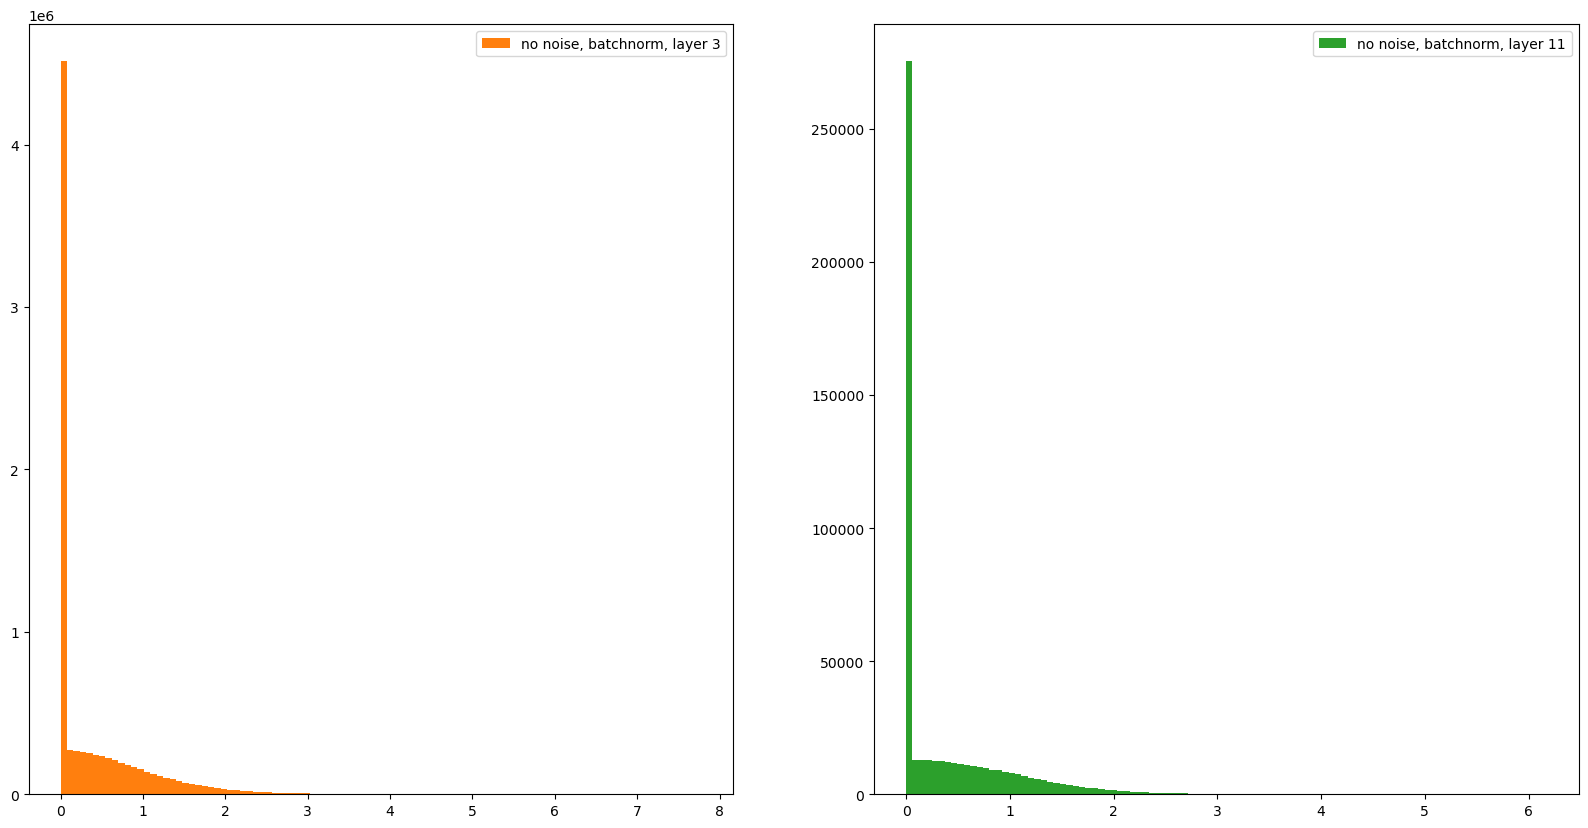

In [12]:

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.hist(b_3.cpu().detach().numpy().flatten(), bins=100, label='no noise, batchnorm, layer 3', color='C1')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(b_11[0].cpu().detach().numpy().flatten(), bins=100, label='no noise, batchnorm, layer 11', color='C2')
plt.legend()
# plt.hist(b_3[0].cpu().detach().numpy().flatten(), bins=100, alpha=0.5, label='batchnorm, layer 3')
# plt.hist(b_11[0].cpu().detach().numpy().flatten(), bins=100, alpha=0.5, label='batchnorm, layer 11')

# plt.hist(m_3[0].cpu().detach().numpy().flatten(), bins=100, alpha=0.5, label='layer 3')
# plt.hist(m_11[0].cpu().detach().numpy().flatten(), bins=100, alpha=0.5, label='layer 11')